In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

# Current-Voltage relationship (I-V)

## 1. Choose the data file you want to analyze

In [2]:
data_file = 'data/Fig_Nav/NAV_Cerv(1)_22712019.abf'

In [3]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(sweeps.shape)
print(sweeps_time.shape)
print(f"freq: {sampling_freq} Hz")

(14, 2, 2500)
(2500,)
freq: 10000.0 Hz


## 2. Plot the traces to get an overview of the data

array([<Axes: ylabel='Voltage (mV)'>,
       <Axes: xlabel='Time (ms)', ylabel='Current (pA)'>], dtype=object)

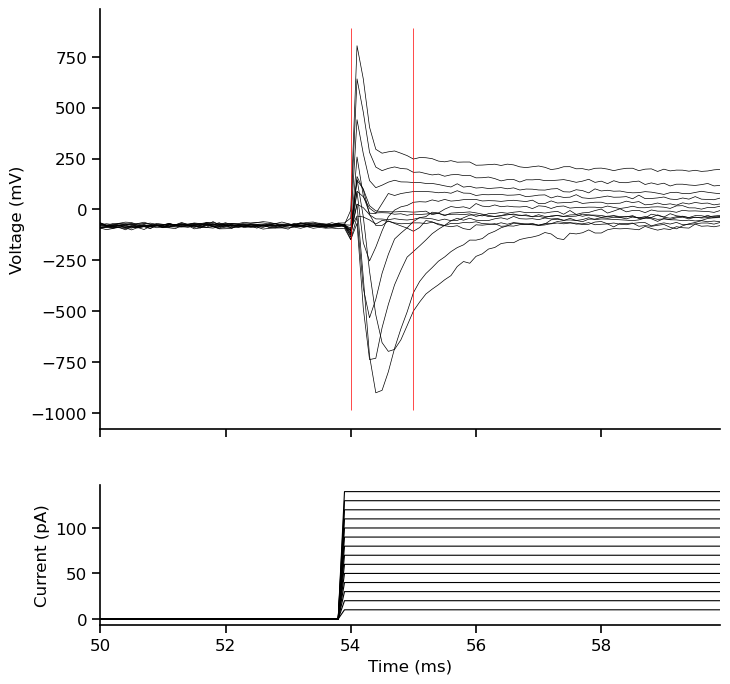

In [4]:
start_time = 50 # milliseconds
end_time = 60 # milliseconds

marker_1 = 54 # milliseconds
marker_2 = 55 # milliseconds

voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
plot_traces(time_in_window, voltage_traces, current_traces, marker_1, marker_2)

## 3. Select what you want to measure:
- define the time window(s) of interest
- define what you want to measure (e.g. mean or peak voltage/current)

### 3.1. Measure baseline

In [5]:
# 1. Measure baseline
start_time = 0 # milliseconds
end_time = 10 # milliseconds
measurement_type = 'mean' # Options: 'mean', 'max', 'min'

baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)
print(baseline_voltage)
print(baseline_current)

[-79.5929 -73.8831 -76.1353 ... -70.2301 -72.3816 -78.3081]
[0. 0. 0. ... 0. 0. 0.]


### 3.2. Apply baseline correction

array([<Axes: ylabel='Voltage (mV)'>,
       <Axes: xlabel='Time (ms)', ylabel='Current (pA)'>], dtype=object)

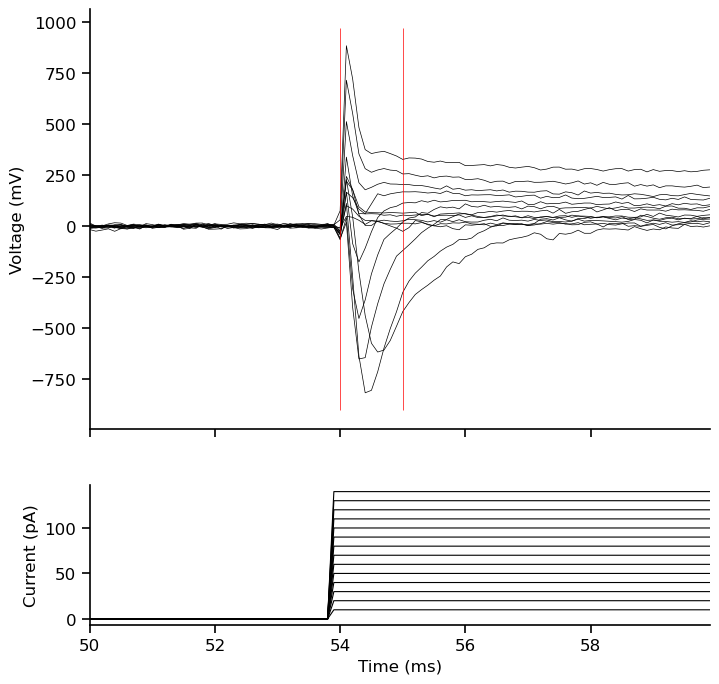

In [6]:
num_traces = sweeps.shape[0]
for i in range(num_traces):
    sweeps[i,0] -= baseline_voltage[i]
    sweeps[i,1] -= baseline_current[i]

plot_traces(time_in_window, voltage_traces, current_traces, marker_1, marker_2)

### 3.3. Measure currents/voltage steps

<Axes: xlabel='V (mV)', ylabel='I (pA)'>

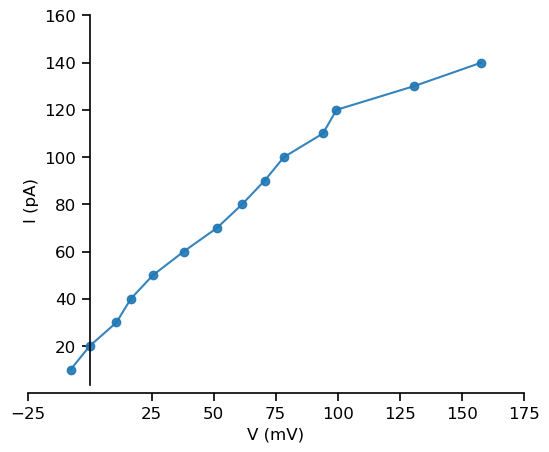

In [7]:
start_time = 100 # milliseconds
end_time = 150 # milliseconds
measurement_type = 'min' # Options: 'mean', 'max', 'min'

voltage_steps, current_steps = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

plot_IV(voltage_steps, current_steps)

### Optional: fit a line to the I-V points and get the slope

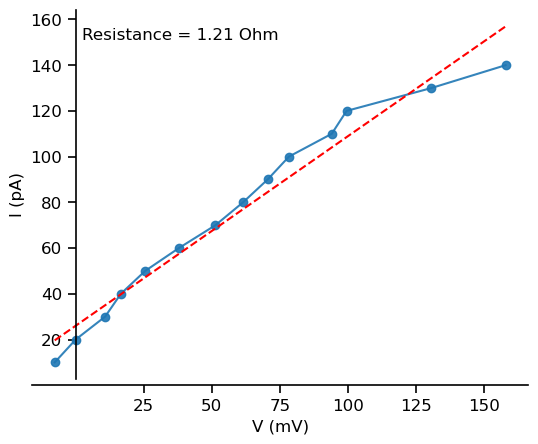

In [8]:
ax = plot_IV(voltage_steps, current_steps)

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(voltage_steps, current_steps)
ax.text(0.1, 0.95, f"Resistance = {1/slope:.2f} Ohm", transform=ax.transAxes, fontsize=12, verticalalignment='top')
ax.plot(voltage_steps, slope * voltage_steps + intercept, linestyle='--', color='r', label='Fit')

### Optional: fit a sigmoid to the I-V points

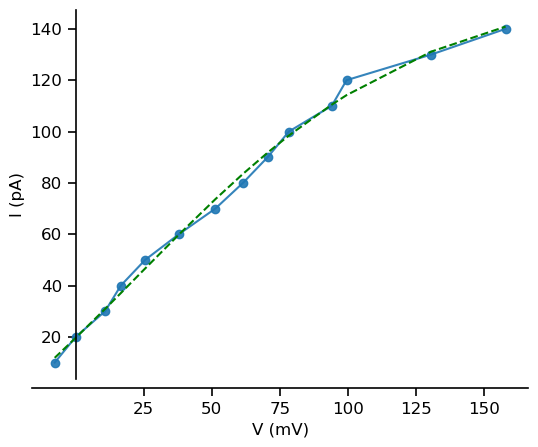

In [9]:
ax = plot_IV(voltage_steps, current_steps)

from scipy.optimize import curve_fit
def sigmoid(x, ymax, x0, slope, ymin):
    return ymax / (1 + np.exp(-slope * (x - x0))) + ymin
p0 = [max(current_steps), np.median(voltage_steps), 1, min(current_steps)]
popt, pcov = curve_fit(sigmoid, voltage_steps, current_steps, p0=p0)
ax.plot(voltage_steps, sigmoid(voltage_steps, *popt), linestyle='--', color='g', label='Fit')

### Optional: fit single exponential to voltage traces to get tau

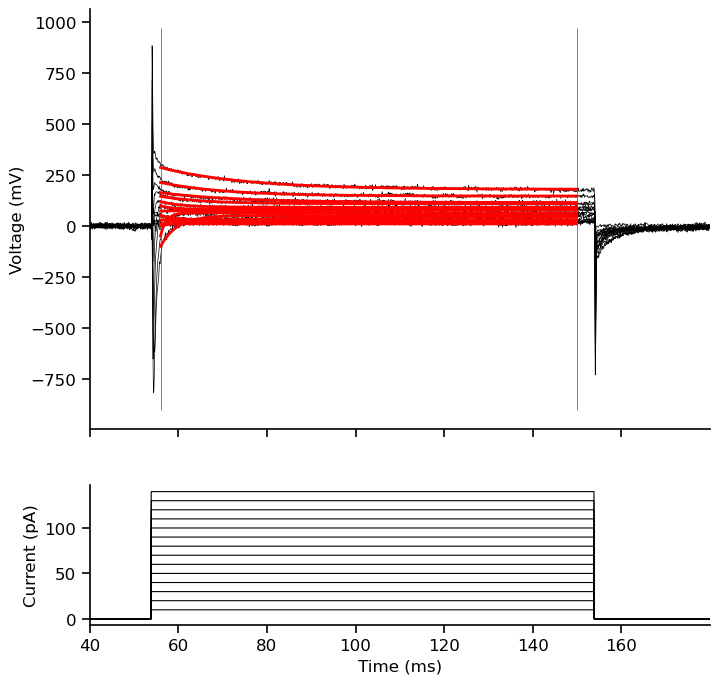

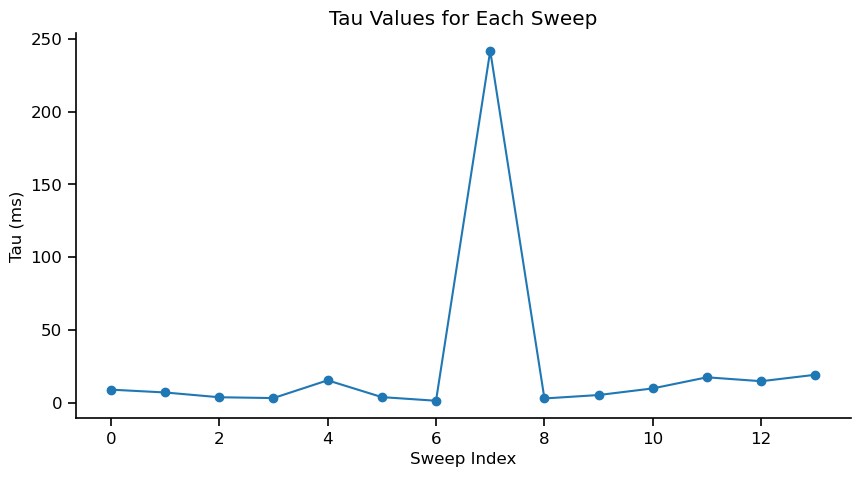

In [10]:
#Fit single exponential to voltage traces to get tau
start_time = 40 # milliseconds
end_time = 180 # milliseconds

marker_1 = 56 # milliseconds
marker_2 = 150 # milliseconds

voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
ax = plot_traces(time_in_window, voltage_traces, current_traces, marker_1, marker_2)

tau_values, ax = plot_expontial_fit(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, ax=ax)